In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# Industrial Site

In this application of the FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [2]:
import FINE as fn         # Provides objects and functions to model an energy system 
import pandas as pd       # Used to manage data in tables
import geopandas as gpd   # Used to display geo-referenced plots
import shapely as shp     # Used to generate geometric objects
import numpy as np        # Used to generate random input data

%load_ext autoreload
%autoreload 2

# Model an energy system

## Specify model configuration

In [3]:
doDSM = True

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [4]:
# Input parameters
locations = {'industry_0'}
commodityUnitDict = {'electricity': r'MW$_{el}$', 'hydrogen': r'MW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps, hoursPerTimeStep = 52560, 1/6 #8760, 1 
costUnit, lengthUnit = '1e3 Euro', 'km'

# Code
esM = fn.EnergySystemModel(locations=locations, commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps, commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep, costUnit=costUnit, lengthUnit=lengthUnit, verboseLogLevel=0)

## Add source component

Source components generate commodities across the energy system's virtual boundaries.

In [5]:
data = pd.read_excel('generationTimeSeries_e825103.xlsx')
operationRateMax = pd.DataFrame(data['e825103_2017_2.3MW_faults9'],index=range(numberOfTimeSteps)) # Dataset with least missing data
operationRateMax.columns = ['industry_0']

In [6]:
# Input parameters
name, commodity ='Wind turbines', 'electricity'
hasCapacityVariable = True
capacityFix = pd.Series([20], index=['industry_0']) # 10 MW_el = 0.01 GW_el
investPerCapacity, opexPerCapacity = 0, 30 # 30 €/kW = 30 1e6€/GW = 30 1e3€/MW
interestRate, economicLifetime = 0.08, 20

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityFix=capacityFix, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [7]:
operationRateMax.sum()

industry_0    12107.056522
dtype: float64

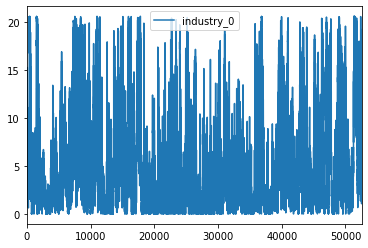

In [8]:
(capacityFix*operationRateMax).plot()

## Add conversion components

In [9]:
esM.add(fn.Conversion(esM=esM, name='PEMEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.67},
                      hasCapacityVariable=True, 
                      investPerCapacity=2300, opexPerCapacity=12.5, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=5))

In [10]:
esM.add(fn.Conversion(esM=esM, name='AEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.64},
                      hasCapacityVariable=True, 
                      investPerCapacity=1300, opexPerCapacity=18, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=9))

## Add storage components

In [11]:
esM.add(fn.Storage(esM=esM, name='Hydrogen tank (gaseous)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=1,
                   chargeRate=1, dischargeRate=1, sharedPotentialID=None,
                   stateOfChargeMin=0.06, stateOfChargeMax=1,
                   investPerCapacity=0.004, opexPerCapacity=0.004*0.02, interestRate=0.08,
                   economicLifetime=20))

### Industrial hydrogen demand

operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=operationRateFix))

In [12]:
operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
if doDSM:
    esM.add(fn.DemandSideManagement(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    tUp=1, tDown=1, operationRateFix=operationRateFix))
else:
    esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    operationRateFix=operationRateFix))

In [13]:
operationRateFix.sum()

industry_0    17520.0
dtype: float64

In [14]:
esM.getComponent('Hydrogen demand').fullOperationRateFix.sum()

industry_0    17520.0
dtype: float64

In [15]:
esM.getComponent('Hydrogen demand_1').hasCapacityVariable

False

In [16]:
esM.getComponent('Hydrogen demand_1').dischargeOpRateFix

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [17]:
# Input parameters
numberOfTypicalPeriods=30
numberOfTimeStepsPerPeriod=24*6

# Code
esM.cluster(numberOfTypicalPeriods=numberOfTypicalPeriods,numberOfTimeStepsPerPeriod=numberOfTimeStepsPerPeriod)


Clustering time series data with 30 typical periods and 144 time steps per period...
		(11.6691 sec)



In [18]:
# Input parameters
timeSeriesAggregation=False
solver='gurobi'

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(22.5416 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(12.7001 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(20.8891 sec)

Declaring sets, variables and constraints for StorageExtModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(34.0388 sec)

Declaring sets, variables and constraints for DSMModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(6.1860 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(16.0275 sec)

Declaring objective function...
		(8.3801 sec)

Using license file C:\Users\LaraWelder\gurobi.lic
Academic license - for non-commercial use only
Read 

  80   1.96803511e+03  2.05438603e+03  1.20e-04 2.69e-05  4.87e-04   132s
  81   1.95765000e+03  2.05131793e+03  1.11e-04 2.60e-05  4.70e-04   134s
  82   1.95108761e+03  2.04813998e+03  1.05e-04 2.51e-05  4.55e-04   135s
  83   1.94503237e+03  2.04521957e+03  9.89e-05 2.44e-05  4.41e-04   137s
  84   1.93971463e+03  2.04047832e+03  8.51e-05 2.34e-05  4.21e-04   138s
  85   1.93307280e+03  2.01897968e+03  7.21e-05 1.90e-05  3.41e-04   140s
  86   1.93346679e+03  2.01009099e+03  4.82e-05 1.74e-05  3.11e-04   141s
  87   1.92242011e+03  1.95621441e+03  1.32e-05 8.51e-06  1.61e-04   143s
  88   1.91201128e+03  1.91950948e+03  1.28e-06 2.27e-06  4.67e-05   144s
  89   1.90943094e+03  1.90975726e+03  2.03e-07 2.59e-07  6.12e-06   145s
  90   1.90891321e+03  1.90898216e+03  7.22e-08 6.96e-08  1.67e-06   147s
  91   1.90877339e+03  1.90874518e+03  6.29e-08 2.96e-09  1.07e-07   148s
  92   1.90875227e+03  1.90873710e+03  1.97e-08 9.41e-10  3.90e-08   149s
  93   1.90874233e+03  1.90873504e+03 

  117737 PPushes remaining with PInf 0.0000000e+00               933s
  116960 PPushes remaining with PInf 0.0000000e+00               938s
  116201 PPushes remaining with PInf 0.0000000e+00               943s
  115411 PPushes remaining with PInf 0.0000000e+00               947s
  114646 PPushes remaining with PInf 0.0000000e+00               952s
  113834 PPushes remaining with PInf 0.0000000e+00               957s
  113000 PPushes remaining with PInf 0.0000000e+00               962s
  112178 PPushes remaining with PInf 0.0000000e+00               967s
  111302 PPushes remaining with PInf 0.0000000e+00               973s
  110474 PPushes remaining with PInf 0.0000000e+00               978s
  109626 PPushes remaining with PInf 0.0000000e+00               983s
  108806 PPushes remaining with PInf 0.0000000e+00               988s
  107922 PPushes remaining with PInf 0.0000000e+00               993s
  107062 PPushes remaining with PInf 0.0000000e+00               998s
  106166 PPushes rem

    9507 PPushes remaining with PInf 0.0000000e+00              1538s
    8393 PPushes remaining with PInf 0.0000000e+00              1542s
    7270 PPushes remaining with PInf 0.0000000e+00              1546s
    6139 PPushes remaining with PInf 0.0000000e+00              1551s
    5020 PPushes remaining with PInf 0.0000000e+00              1556s
    3944 PPushes remaining with PInf 0.0000000e+00              1562s
    2884 PPushes remaining with PInf 0.0000000e+00              1567s
    1811 PPushes remaining with PInf 0.0000000e+00              1573s
    1293 PPushes remaining with PInf 0.0000000e+00              1576s
     274 PPushes remaining with PInf 0.0000000e+00              1583s
       0 PPushes remaining with PInf 0.0000000e+00              1588s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6008555e+00   1588s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  257758    1.9087339e+03   0.000000e+00   1.600855e+00   1594s
  258116    1.9087339e+03   0.

## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

#### Source and Sink Component

In [26]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

industry_0
Component     Property  Unit                      
Wind turbines TAC       [1e3 Euro/a]           600
              capacity  [MW$_{el}$]             20
              operation [MW$_{el}$*h/a]      27375
              opexCap   [1e3 Euro/a]           600

#### Conversion Components

In [27]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

industry_0
Component Property  Unit                      
AEC       TAC       [1e3 Euro/a]       1308.73
          capacity  [MW$_{el}$]         5.7882
          capexCap  [1e3 Euro/a]       1204.55
          invest    [1e3 Euro]         7524.67
          operation [MW$_{el}$*h/a]      27375
          opexCap   [1e3 Euro/a]       104.188

#### Storage Components

In [28]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=1)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

,,,industry_0
Component,Property,Unit,


#### DSM Components

In [29]:
if doDSM:
    DSMSummary = esM.getOptimizationSummary("DSMModel", outputLevel=1)
    display(esM.getOptimizationSummary("DSMModel", outputLevel=2))

,,,industry_0
Component,Property,Unit,
Hydrogen demand,operation,"[MW$_{H_{2},LHV}$*h/a]",17520


## Display regional and operational plots

Plots representing time series can be displayed for each component.

### Wind turbines

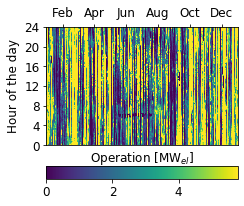

In [30]:
# If wind turbines are built in industry_0, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'industry_0', figsize=(3.5,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        zlabel='', nbTimeStepsPerPeriod=24*6)

### Electrolyzers 

In [31]:
# If PEMECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('PEMEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PEMEC', 'industry_0', figsize=(4,3), 
        monthlabels=True, xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6),
        yticklabels=range(0,25,4), zlabel='Power [MW]', nbTimeStepsPerPeriod=24*6)

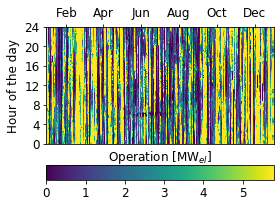

In [32]:
# If AECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('AEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    ts = fn.plotOperationColorMap(esM, 'AEC', 'industry_0', figsize=(4,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', 
        nbTimeStepsPerPeriod=24*6, yticks=range(0,24*6+1,6*4), yticklabels=range(0,25,4))

### Gaseous Hydrogen Tank

In [33]:
# If Gaseous Hydrogen Tanks are built in industry_0, their storage inventory is displayed as heatmap
if storSummary.loc[('Hydrogen tank (gaseous)','capacity','[MW$_{H_{2},LHV}$*h]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen tank (gaseous)', 'industry_0', figsize=(4,3),
        variableName='stateOfChargeOperationVariablesOptimum', monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        nbTimeStepsPerPeriod=24*6)

### Hydrogen Demand

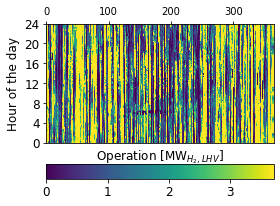

In [34]:
# The hydrogen demand time series in industry_0 is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen demand', 'industry_0', figsize=(4,3), 
    yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
    xlabel='', ylabel='Hour of the day', nbTimeStepsPerPeriod=24*6)